In [7]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [8]:
import mne
from pprint import pprint
import json
import csv
import numpy as np

import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

/Users/neuroling/Downloads/20250610_EEG-Demo
Reading 0 ... 407295  =      0.000 ...   397.749 secs...
Using pyopengl with version 3.1.1a1
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 1 EOG, 1 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 07:34:08 UTC
 nchan: 2
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 5 items (dict)
>
Effective window size : 2.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_original_MMN_noNotch.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_original_MMN_noNotch.fif
[done]


/Users/neuroling/anaconda3/envs/eelbrain/lib/python3.11/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/2965499081.py:28: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_original_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  n_MMN_raw.save(fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), overwrite=True)


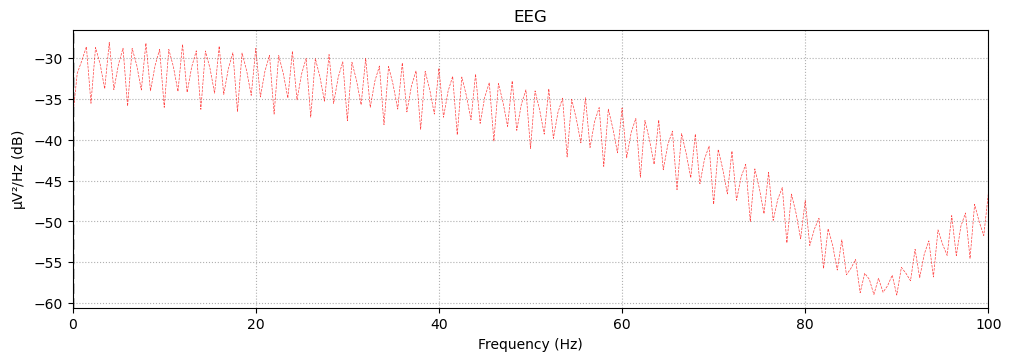

Channels marked as bad:
['Trigger']


In [90]:
# Use the .fif files produced from kit2fiff packages
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)

# new = new gel ; original: old gel

EEG_cntFile = root_data_path / Path('eeg_20250610_test_original_MMN_noNotch.cnt') #eeg_20250610_test_original_noNotch.cnt
#LDT_raw =  mne.io.read_raw_kit(LDT_confile, stim = [195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進
#LDT_raw.plot()
#events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

MMN_raw = mne.io.read_raw_cnt(EEG_cntFile, eog="header", preload=True)
#MMN_raw.plot()

n_MMN_raw = MMN_raw.copy()
#n_MMN_filtered = n_MMN_raw.notch_filter(freqs=50, picks="all")
n_MMN_raw.plot()
#n_MMN_filtered.plot()
print(n_MMN_raw.info)

# Calculate the power spectrum density to examine the power in each frequency.
n_MMN_raw.compute_psd(fmax=100).plot()#.(fmax=100)

# Save the cnt into .fif for a easier further analysis
fif_DIR = root_data_path / 'rawfif_all'
fif_DIR.mkdir(exist_ok=True)

n_MMN_raw.save(fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), overwrite=True)

In [53]:
n_MMN_raw.ch_names # Where are the annotations

['Fz_1', 'Trigger']

In [84]:
# This is the original brain data's triggers
'''
Triggers_ID:
12345 >> the start of task
55 >> the end of task
20 ~ 24 >> the start of questions' texts (irrelevant in here, please ignore it)
'''

## Segment the EEG according to tasks, 5 parts in total.
events_ann_ndArray = mne.events_from_annotations(n_MMN_raw)[0]
print(events_ann_ndArray)
print(type(events_ann_ndArray))
print(len(events_ann_ndArray))
print(mne.events_from_annotations(n_MMN_raw)[1], len(mne.events_from_annotations(n_MMN_raw)[1]))

events_id_DICT = {'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11}
raw_sfreq = n_MMN_raw.info['sfreq'] # supposedly to be 1000 Hz
fifname_LIST = ["eyeOpen_2min", "eyeClose_2min", "Blink_60count", "HEOG_60count", "VEOG_60count"]

# Get the start points in every 3 segment, staring from index[0]
start_tNDarray = events_ann_ndArray[::3]
print(start_tNDarray)
print(len(start_tNDarray))

# Get the end points in every 3 segment, staring from index[2]
end_tNDarray = events_ann_ndArray[2::3]
print(end_tNDarray)
print(len(end_tNDarray))

# segment the EEG data according to the points that are going to be converted into times, and save the raw EEG files
for i in range(5):
    print(start_tNDarray[i][0]/int(raw_sfreq), end_tNDarray[i][0]/int(raw_sfreq))
    # in here, we exclude the +0.5 at the end of the end points for the reason of 0.5 delay when the questions start trigger appear
    cut_eeg = n_MMN_raw.copy().crop((start_tNDarray[i][0]/int(raw_sfreq)), (end_tNDarray[i][0]/int(raw_sfreq)))
    cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


"""
epochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)
                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)
"""

Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
[[  8744      0      1]
 [ 68651      0      3]
 [144131      0     11]
 [146165      0      2]
 [209144      0      4]
 [278897      0     11]
 [280916      0      8]
 [346966      0      5]
 [357762      0     11]
 [359970      0      9]
 [432166      0      6]
 [439272      0     11]
 [441476      0     10]
 [510597      0      7]
 [520315      0     11]]
<class 'numpy.ndarray'>
15
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
{'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11} 11
[[  8744      0      1]
 [146165      0      2]
 [280916      0      8]
 [359970      0      9]
 [441476      0     10]]
5
[[144131      0     11]
 [278897      0     11]
 [357762      0     11]
 [439272      0     11]
 [520315      

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeOpen_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeClose_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_L

Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/HEOG_60count_new_Notched.fif
[done]
431.12890625 508.1201171875
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
[done]


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


'\nepochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)\n                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)\n'

In [122]:
# MMN data analysis
rawfif_datapath = fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif')

raw_MMN_fif = mne.io.read_raw_fif(rawfif_datapath, preload=True)
raw_MMN_fif.plot()
MMN_eventsArray = mne.events_from_annotations(raw_MMN_fif)[0]
print(len(MMN_eventsArray[0]), MMN_eventsArray)

# Creating the new epochs
MMN_events = MMN_eventsArray#mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
MMN_event_id = {'standard':1,'deviant_2':2, 'deviant_3': 3}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

#raw_MMN_fif.filter(0, 30, phase= 'zero-double').resample(500)
n_epoch_MMN = mne.Epochs(raw_MMN_fif, MMN_events, MMN_event_id, tmin, tmax, baseline=baseline, preload = True)

n_epoch_MMN

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_original_MMN_noNotch.fif...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/2498649508.py:4: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_original_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_MMN_fif = mne.io.read_raw_fif(rawfif_datapath, preload=True)


    Range : 0 ... 407295 =      0.000 ...   397.749 secs
Ready.
Reading 0 ... 407295  =      0.000 ...   397.749 secs...
Using pyopengl with version 3.1.1a1
Used Annotations descriptions: ['1', '2', '3', '4']
3 [[  3711      0      4]
 [  4480      0      4]
 [  5248      0      4]
 ...
 [400848      0      3]
 [401616      0      1]
 [402384      0      1]]
Not setting metadata
500 matching events found
Setting baseline interval to [-0.099609375, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 500 events and 820 original time points ...
0 bad epochs dropped


Number of events,500
Events,deviant_2: 50deviant_3: 50standard: 400
Time range,-0.100 – 0.700 s
Baseline,-0.100 – 0.000 s


Channels marked as bad:
['Trigger']


In [140]:
# MMN data analysis
rawfif_datapath = fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif')

raw_MMN_fif = mne.io.read_raw_fif(rawfif_datapath, preload=True)
# Check whether the ch exists
print(raw_MMN_fif.info['ch_names'])
print(raw_MMN_fif.get_channel_types())
# Rename the channels
raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})

raw_MMN_fif.plot()
MMN_eventsArray = mne.events_from_annotations(raw_MMN_fif)[0]
print(len(MMN_eventsArray[0]), MMN_eventsArray)


# Creating the new epochs
MMN_events = MMN_eventsArray#mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
MMN_event_id = {'standard':1,'deviant_2':2, 'deviant_3': 3}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

raw_MMN_fif.filter(0, 30, phase= 'zero-double').resample(500)
n_epoch_MMN = mne.Epochs(raw_MMN_fif, MMN_events, MMN_event_id, tmin, tmax, baseline=baseline, preload = True)

n_epoch_MMN

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_original_MMN_noNotch.fif...
    Range : 0 ... 407295 =      0.000 ...   397.749 secs
Ready.
Reading 0 ... 407295  =      0.000 ...   397.749 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/3794087401.py:4: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eeg_20250610_test_original_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_MMN_fif = mne.io.read_raw_fif(rawfif_datapath, preload=True)


Using pyopengl with version 3.1.1a1
Used Annotations descriptions: ['1', '2', '3', '4']
3 [[  3711      0      4]
 [  4480      0      4]
 [  5248      0      4]
 ...
 [400848      0      3]
 [401616      0      1]
 [402384      0      1]]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 451 samples (0.440 s)

Not setting metadata
500 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 500 events and 401 original time points ...
266 bad epochs dropped


Number of events,234
Events,deviant_2: 24deviant_3: 23standard: 187
Time range,-0.100 – 0.700 s
Baseline,-0.100 – 0.000 s


Channels marked as bad:
['Trigger']


In [141]:
# epochs to evoked
evoked_standard = n_epoch_MMN['standard'].average()
evoked_deviant_2 = n_epoch_MMN['deviant_2'].average()
evoked_deviant_3 = n_epoch_MMN['deviant_3'].average()

# Plot mmn differences
tmp = [evoked_standard, evoked_deviant_2, evoked_deviant_3]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mne.viz.plot_compare_evokeds(tmp, colors = colors, axes = 'topo')

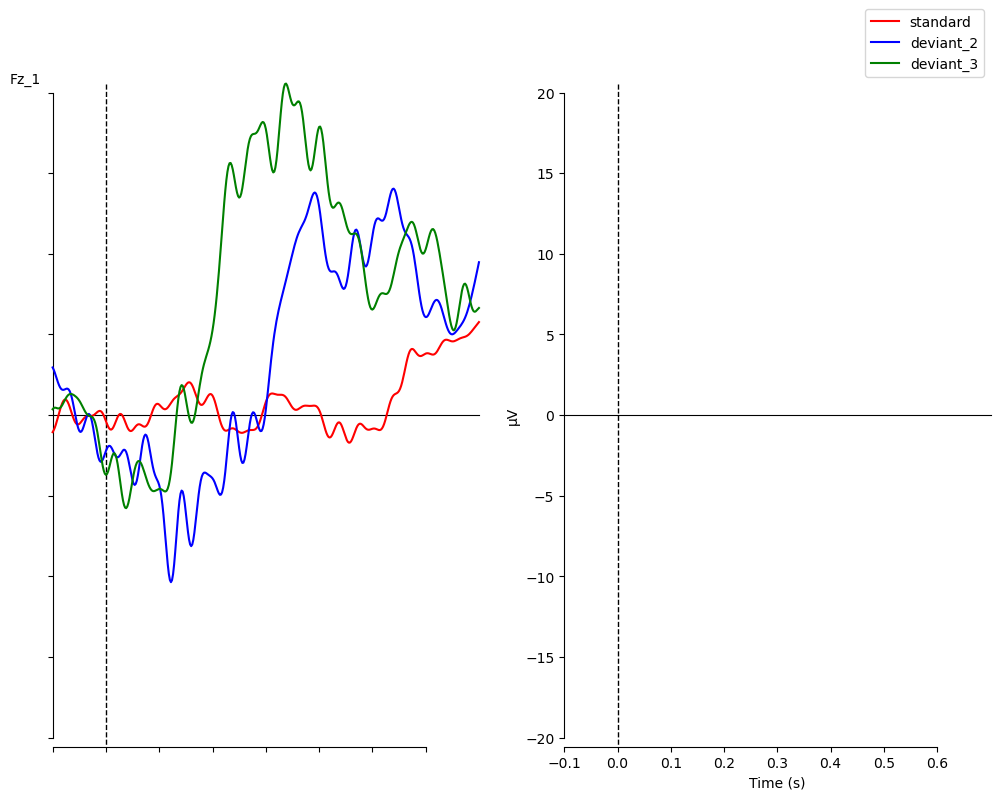

[<Figure size 1800x1400 with 2 Axes>]

Need more than one channel to make topography for eeg. Disabling interactivity.


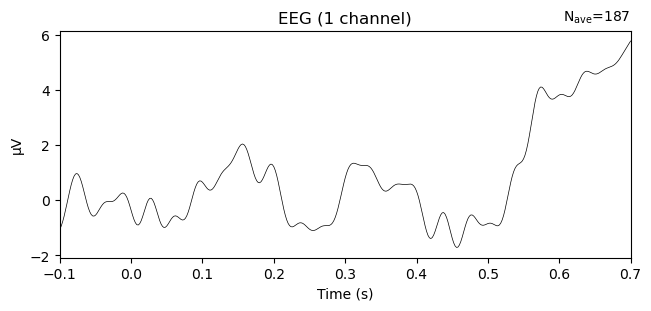

Need more than one channel to make topography for eeg. Disabling interactivity.


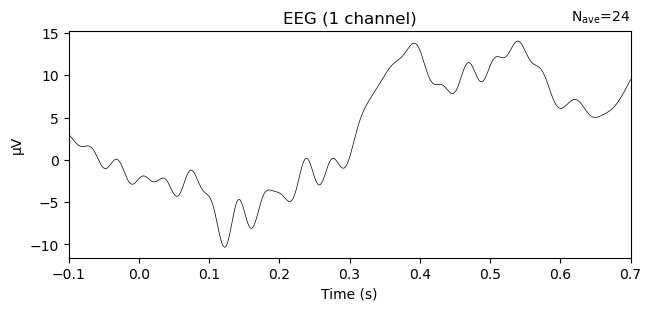

Need more than one channel to make topography for eeg. Disabling interactivity.


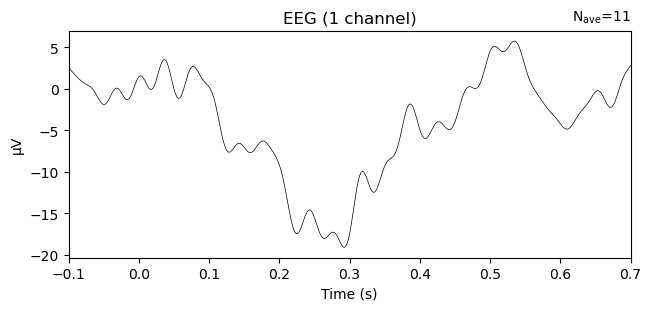

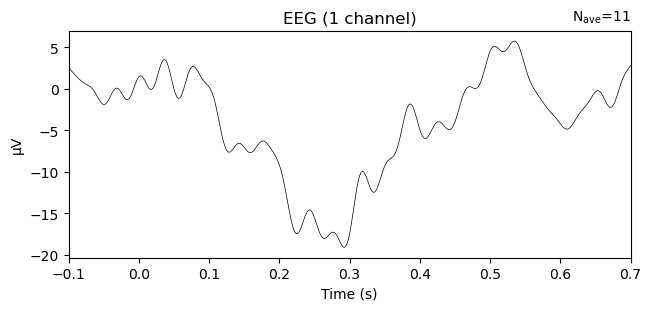

In [144]:
# Useless
evoked_standard.plot(picks='Fz_1')
evoked_deviant_2.plot(picks='Fz_1')

mmn_2 = mne.combine_evoked([evoked_standard, evoked_deviant_2], weights=[1, -1])
mmn_3 = mne.combine_evoked([evoked_standard, evoked_deviant_3], weights=[1, -1])
colors = 'blue', 'green'
mmn.plot(picks='Fz_1')

In [3]:
spectrum = n_MMN_raw.compute_psd().plot
spectrum.plot(picks='Fz_1', average=True, amplitude=False) #, exclude="bads", amplitude=False)

Effective window size : 2.000 (s)


ValueError: picks ('Fz_1') could not be interpreted as channel names (no channel "['Fz_1']"), channel types (no type "Fz_1" present), or a generic type (just "all" or "data")

Channels marked as bad:
['Trigger']


In [14]:
n_MMN_raw.load_data().notch_filter(freqs=60)#.filter(0, 30, phase='zero-double').resample(500). #raw.notch_filter(freqs=60)  # US/Canada
picks = mne.pick_types(n_MMN_raw.info, eeg=True, eog=True, exclude='bads')
n_MMN_raw.plot()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6759 samples (6.601 s)

Using pyopengl with version 3.1.1a1


Channels marked as bad:
['Trigger']
Channels marked as bad:
['Trigger']


In [24]:
# get to know the reason of bad epoch drop
print(epoch_LDT.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 117',), (), ())
